This notebook is still work in progress and tries to use several GPUs for the calibration.

It seems to be running well, but we did not had time to investigate how the batch size, numbers of workers, etc... affects the timings.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax


jax.devices()

[CudaDevice(id=0), CudaDevice(id=1)]

# Loading data

## Xarray data

In [3]:
data_root = "/summer/meom"

In [4]:
import clouddrift as cd
import numpy as np
import xarray as xr

### Drifters

In [5]:
drifter_ds = xr.open_zarr(f"{data_root}/workdir/bertrava/noaa-oar-hourly-gdp-pds.zarr")
drifter_ds

<xarray.Dataset> Size: 102MB
Dimensions:  (traj: 1382, obs: 3189334)
Coordinates:
    id       (traj) int64 11kB dask.array<chunksize=(1382,), meta=np.ndarray>
    time     (obs) datetime64[ns] 26MB dask.array<chunksize=(385186,), meta=np.ndarray>
Dimensions without coordinates: traj, obs
Data variables:
    lat      (obs) float64 26MB dask.array<chunksize=(385186,), meta=np.ndarray>
    lon      (obs) float64 26MB dask.array<chunksize=(385186,), meta=np.ndarray>
    rowsize  (traj) int32 6kB dask.array<chunksize=(1382,), meta=np.ndarray>
    ve       (obs) float32 13MB dask.array<chunksize=(385186,), meta=np.ndarray>
    vn       (obs) float32 13MB dask.array<chunksize=(385186,), meta=np.ndarray>
Attributes: (12/18)
    Conventions:          CF-1.6
    acknowledgement:      Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centu...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    date_created:         2024-07-30T19:02:16.200531
    doi:                  10.25921/x46c-3620
    ...                   ...
    publisher_name:       GDP Drifter DAC
    publisher_url:        https://www.aoml.noaa.gov/phod/gdp
    summary:              Global Drifter Program hourly data
    time_coverage_end:    2022-10-31:00:00:00Z
    time_coverage_start:  1987-10-02:13:00:00Z
    title:                Global Drifter Program hourly drifting buoy collection

In [6]:
def chunk_trajectories(
    ds: xr.Dataset, n_days: int = 5, dt: np.timedelta64 = np.timedelta64(1, "h"), to_ragged: bool = False
) -> xr.Dataset:
    def ragged_chunk(arr: xr.DataArray | np.ndarray, is_metadata: bool = False) -> np.ndarray:
        arr = cd.ragged.apply_ragged(cd.ragged.chunk, arr, row_size, chunk_size)  # noqa
        if is_metadata:
            arr = arr[:, 0]
        if to_ragged:
            arr = arr.ravel()
        return arr

    if dt is None:
        dt = (ds.isel(traj=0).time[1] - ds.isel(traj=0).time[0])

    row_size = cd.ragged.segment(ds.time, dt, ds.rowsize)  # if holes, divide into segments
    chunk_size = int(n_days / (dt / np.timedelta64(1, "D"))) + 1

    # chunk along `obs` dimension (data)
    data = dict(
        [(d, ragged_chunk(ds[d])) for d in ["time", "lat", "lon"]]
    )

    # chunk along `traj` dimension (metadata)
    metadata = {"id": ragged_chunk(np.repeat(ds["id"], ds.rowsize), is_metadata=True)}
    metadata["rowsize"] = np.full(metadata["id"].size, chunk_size)  # noqa - after chunking the rowsize is constant

    # create xr.Dataset
    attrs_global = ds.attrs

    coord_dims = {}
    attrs_variables = {}
    for var in ds.coords.keys():
        var = str(var)
        coord_dims[var] = str(ds[var].dims[-1])
        attrs_variables[var] = ds[var].attrs

    for var in data.keys():
        attrs_variables[var] = ds[var].attrs

    for var in metadata.keys():
        attrs_variables[var] = ds[var].attrs

    metadata["drifter_id"] = metadata["id"]  # noqa
    del metadata["id"]
    attrs_variables["drifter_id"] = attrs_variables["id"]
    attrs_variables["id"] = {}

    if to_ragged:
        coords = {"id": np.arange(metadata["drifter_id"].size), "time": data.pop("time")}
        ragged_array = cd.RaggedArray(
            coords, metadata, data, attrs_global, attrs_variables, {"traj": "rows", "obs": "obs"}, coord_dims
        )
        ds = ragged_array.to_xarray()
    else:
        coords = {"id": np.arange(metadata["drifter_id"].size)}
        
        xr_coords = {}
        for var in coords.keys():
            xr_coords[var] = (
                [coord_dims[var]],
                coords[var],
                attrs_variables[var],
            )

        xr_data = {}
        for var in metadata.keys():
            xr_data[var] = (
                ["traj"],
                metadata[var],
                attrs_variables[var],
            )

        for var in data.keys():
            xr_data[var] = (
                ["traj", "obs"],
                data[var],
                attrs_variables[var],
            )

        ds = xr.Dataset(coords=xr_coords, data_vars=xr_data, attrs=attrs_global)

    return ds

In [7]:
traj_ds = chunk_trajectories(drifter_ds)
traj_ds

<xarray.Dataset> Size: 73MB
Dimensions:     (traj: 25069, obs: 121)
Coordinates:
    id          (traj) int64 201kB 0 1 2 3 4 5 ... 25064 25065 25066 25067 25068
Dimensions without coordinates: traj, obs
Data variables:
    rowsize     (traj) int64 201kB 121 121 121 121 121 ... 121 121 121 121 121
    drifter_id  (traj) int64 201kB 72212 72212 72212 72212 ... 39292 41602 41598
    time        (traj, obs) datetime64[ns] 24MB 2010-01-01 ... 2010-12-31T15:...
    lat         (traj, obs) float64 24MB -31.83 -31.84 -31.84 ... 15.44 15.44
    lon         (traj, obs) float64 24MB 84.96 84.97 84.97 ... 152.6 152.6 152.6
Attributes: (12/18)
    Conventions:          CF-1.6
    acknowledgement:      Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centu...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    date_created:         2024-07-30T19:02:16.200531
    doi:                  10.25921/x46c-3620
    ...                   ...
    publisher_name:       GDP Drifter DAC
    publisher_url:        https://www.aoml.noaa.gov/phod/gdp
    summary:              Global Drifter Program hourly data
    time_coverage_end:    2022-10-31:00:00:00Z
    time_coverage_start:  1987-10-02:13:00:00Z
    title:                Global Drifter Program hourly drifting buoy collection

### Surface currents

In [8]:
ssc_ds = xr.open_zarr(f"{data_root}/workdir/bertrava/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D.zarr")
ssc_ds

<xarray.Dataset> Size: 24GB
Dimensions:    (latitude: 1440, longitude: 2880, time: 365)
Coordinates:
  * latitude   (latitude) float32 6kB -89.94 -89.81 -89.69 ... 89.69 89.81 89.94
  * longitude  (longitude) float32 12kB -179.9 -179.8 -179.7 ... 179.8 179.9
  * time       (time) datetime64[ns] 3kB 2010-01-01 2010-01-02 ... 2010-12-31
Data variables:
    ugos       (time, latitude, longitude) float64 12GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 12GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.6
    comment:                   Sea Surface Height measured by Altimetry and d...
    contact:                   servicedesk.cmems@mercator-ocean.eu
    copernicusmarine_version:  2.0.1
    history:                   2024-10-23 12:55:06Z: Creation
    institution:               CLS, CNES
    references:                http://marine.copernicus.eu
    source:                    Altimetry measurements
    title:                     DT merged all satellites Global Ocean Gridded ...

## Datasets

In [9]:
from torch.utils.data import Dataset as TorchDataset

In [10]:
class XarrayJAXDataset(TorchDataset):
    def __init__(self, traj_ds: xr.Dataset, ssc_ds: xr.Dataset):
        self.traj_ds = traj_ds
        self.ssc_ds = ssc_ds

    def __len__(self):
        return self.traj_ds.traj.size

    def __getitem__(self, idx: int):
        traj_arrays = self.__get_traj_arrays(idx)
        ssc_arrays = self.__get_ssc_arrays(*traj_arrays[:3])

        traj_arrays = [np.asarray(arr) for arr in traj_arrays]
        ssc_arrays = [np.asarray(arr) for arr in ssc_arrays]
        
        return traj_arrays, ssc_arrays
    
    def __get_traj_arrays(self, idx: int):
        traj_subset = self.traj_ds.isel(traj=idx)
        
        traj_lat = traj_subset.lat.values.ravel()
        traj_lon = traj_subset.lon.values.ravel()
        traj_time = traj_subset.time.values.ravel().astype("datetime64[s]").astype(int)  # in seconds
        traj_id = traj_subset.id.values.ravel()
        
        return traj_lat, traj_lon, traj_time, traj_id
    
    def __get_ssc_arrays(self, traj_lat, traj_lon, traj_time):
        one_day_in_seconds = 60 * 60 * 24
        min_time = traj_time[0] - one_day_in_seconds
        max_time = traj_time[-1] + one_day_in_seconds
        n_days = (max_time - min_time) / one_day_in_seconds

        max_travel_distance = .5  # in °/day ; inferred from data
        max_travel_distance *= n_days  # in °

        x0 = np.asarray((traj_lat[0], traj_lon[0]))
        min_corner = x0 - max_travel_distance
        max_corner = x0 + max_travel_distance

        min_latitude = max(-90, min_corner[0])
        max_latitude = min(90, max_corner[0])
        min_longitude = max(-180, min_corner[1])
        max_longitude = min(180, max_corner[1])
        
        ssc_patch = self.ssc_ds.sel(
            longitude=slice(min_longitude, max_longitude),
            latitude=slice(min_latitude, max_latitude),
            time=slice(np.datetime64(min_time.item(), "s"), np.datetime64(max_time.item() - 1, "s"))
        )

        ssc_u = ssc_patch.ugos.values
        ssc_v = ssc_patch.vgos.values
        ssc_time = ssc_patch.time.values.astype("datetime64[s]").astype(int)  # in seconds
        ssc_lat = ssc_patch.latitude.values
        ssc_lon = ssc_patch.longitude.values
        
        return ssc_u, ssc_v, ssc_time, ssc_lat, ssc_lon

In [11]:
xr_jax_dataset = XarrayJAXDataset(traj_ds, ssc_ds)

## Dataloader

In [12]:
import dask
import equinox as eqx
import jax.numpy as jnp
import jax.random as jrd
import jax.sharding as jshard
from pastax.gridded import Gridded
from pastax.trajectory import Trajectory
from torch.utils.data import DataLoader

In [13]:
DASK_N_WORKERS = 2
DL_N_WORKERS = 8
BATCH_SIZE = 64
PREFETCH_FACTOR = 2

In [14]:
@eqx.filter_jit  # this improves performances
def to_trajectories(traj_arrays):
    traj_lat, traj_lon, traj_time, traj_id = traj_arrays

    traj_latlon = jnp.asarray(jnp.stack((traj_lat, traj_lon), axis=-1))
    trajectories = eqx.filter_vmap(
        lambda _latlon, _time, _id: Trajectory.from_array(values=_latlon, times=_time, id=_id)
    )(
        traj_latlon, jnp.asarray(traj_time), jnp.asarray(traj_id)
    )

    return trajectories


@eqx.filter_jit  # this improves performances
def to_gridded(ssc_arrays):
    ssc_u, ssc_v, ssc_time, ssc_lat, ssc_lon = ssc_arrays
    
    gridded = eqx.filter_vmap(Gridded.from_array)(
        {"u": jnp.asarray(ssc_u), "v": jnp.asarray(ssc_v)}, 
        jnp.asarray(ssc_time), jnp.asarray(ssc_lat), jnp.asarray(ssc_lon)
    )

    return gridded

In [15]:
def xr_jax_collate_fn(batch: ((np.ndarray, ...), (np.ndarray, ...))):
    traj_arrays = [[] for _ in range(4)]
    ssc_arrays = [[] for _ in range(5)]

    for elem in batch:
        _traj_arrays, _ssc_arrays = elem

        if _ssc_arrays[0].shape != (7, 56, 56):  # dirty trick. prefer to extend the domain in the previous step
                continue
        
        [traj_arrays[i].append(_traj_arrays[i]) for i in range(len(_traj_arrays))]
        [ssc_arrays[i].append(_ssc_arrays[i]) for i in range(len(_ssc_arrays))]

    traj_arrays = [np.stack(traj_array) for traj_array in traj_arrays]
    ssc_arrays = [np.stack(ssc_array) for ssc_array in ssc_arrays]

    return traj_arrays, ssc_arrays

In [16]:
@eqx.filter_jit  # this improves performances
def to_trajectories(traj_arrays):
    traj_lat, traj_lon, traj_time, traj_id = traj_arrays

    traj_latlon = jnp.asarray(jnp.stack((traj_lat, traj_lon), axis=-1))
    trajectories = eqx.filter_vmap(
        lambda _latlon, _time, _id: Trajectory.from_array(values=_latlon, times=_time, id=_id)
    )(
        traj_latlon, jnp.asarray(traj_time), jnp.asarray(traj_id)
    )

    return trajectories


@eqx.filter_jit  # this improves performances
def to_gridded(ssc_arrays):
    ssc_u, ssc_v, ssc_time, ssc_lat, ssc_lon = ssc_arrays
    
    gridded = eqx.filter_vmap(Gridded.from_array)(
        {"u": jnp.asarray(ssc_u), "v": jnp.asarray(ssc_v)}, 
        jnp.asarray(ssc_time), jnp.asarray(ssc_lat), jnp.asarray(ssc_lon)
    )

    return gridded

# Calibrating

## Defining the dynamics

In [17]:
from pastax.dynamics import StochasticSmagorinskyDiffusion
from pastax.simulator import StochasticSimulator

In [18]:
simulator = StochasticSimulator()
dynamics = StochasticSmagorinskyDiffusion.from_cs(cs=1e-1)

In [19]:
INTEGRATION_DT = 30 * 60  # 30 minutes in seconds
ENSEMBLE_SIZE = 50

In [20]:
def forward(_dynamics, grid, x0, ts, key):
    return simulator(dynamics=_dynamics, args=grid, x0=x0, ts=ts, dt0=INTEGRATION_DT, n_samples=ENSEMBLE_SIZE, key=key)

jitted_forward = eqx.filter_jit(forward)

## Calibration procedure

In [21]:
import itertools
import time

import optax
import pandas as pd

In [22]:
def loss(_dynamics, _grid_batch, _reference_trajectory_batch, _key_batch):
    def pair_residual(traj1, traj2):
        residuals = traj1.liu_index(traj2).value
        residuals = jnp.where(jnp.isnan(residuals), 1, residuals)
        return residuals
    
    def _loss(grid, reference_trajectory, key):
        x0 = reference_trajectory.origin
        ts = reference_trajectory.times.value
        simulated_ensemble = forward(_dynamics, grid, x0, ts, key)
        residuals = simulated_ensemble.crps(reference_trajectory, pair_residual, is_metric_symmetric=False)
        return (residuals ** 2).sum().value
    
    loss_batch = eqx.filter_vmap(_loss)(_grid_batch, _reference_trajectory_batch, _key_batch)
    _loss = loss_batch.mean()

    return _loss, _loss  # for returning both grad and value in forward AD mode

grad_val_loss = eqx.filter_jacfwd(loss, has_aux=True)

In [23]:
@eqx.filter_jit(donate="all")
def make_step(_dynamics, _grid_batch, _reference_trajectory_batch, _key_batch, _optim, _opt_state):
    grad, loss_val = grad_val_loss(_dynamics, _grid_batch, _reference_trajectory_batch, _key_batch)
    updates, _opt_state = _optim.update(grad, _opt_state)
    _dynamics = eqx.apply_updates(_dynamics, updates)

    return loss_val, _dynamics, _opt_state

In [24]:
N_EPOCHS = 1
LEARNING_RATE = 1e-3

In [ ]:
def do_calibrate(dynamics, dask_n_workers, batch_size, dl_n_workers, prefetch_factor):
    dask.config.set(scheduler="threads", num_workers=dask_n_workers)

    xr_jax_dataloader = DataLoader(
        xr_jax_dataset,
        batch_size=batch_size, shuffle=True,
        collate_fn=xr_jax_collate_fn,
        num_workers=dl_n_workers, prefetch_factor=prefetch_factor,
        persistent_workers=True, multiprocessing_context="fork"
    )

    num_devices = len(jax.devices())
    mesh = jax.make_mesh((num_devices,), ("batch",))
    sharded = jshard.NamedSharding(mesh, jshard.PartitionSpec("batch"))  # split across GPUs (samples)
    replicated = jshard.NamedSharding(mesh, jshard.PartitionSpec())  # replicate across GPUs (model)

    key = jrd.key(0)
    optim = optax.adam(LEARNING_RATE)
    opt_state = optim.init(dynamics)

    dynamics, opt_state = eqx.filter_shard((dynamics, opt_state), replicated)

    losses = []
    cs = []

    t0 = time.time()
    n_samples = 0
    for epoch in range(N_EPOCHS):
        key = jrd.split(key, 1)[0]
        for step, (reference_trajectory_batch, grid_batch) in enumerate(xr_jax_dataloader):
            batch_size = reference_trajectory_batch[0].shape[0]
            if (batch_size % num_devices) != 0:
                continue

            batch_key, key = jrd.split(key, 2)
            key_batch = jrd.split(batch_key, batch_size)

            grid_batch, reference_trajectory_batch, key_batch = eqx.filter_shard(
                (grid_batch, reference_trajectory_batch, key_batch), sharded
            )

            reference_trajectory_batch = to_trajectories(reference_trajectory_batch)
            grid_batch = to_gridded(grid_batch)

            loss_val, dynamics, opt_state = make_step(
                dynamics, grid_batch, reference_trajectory_batch, key_batch, optim, opt_state
            )
            losses.append(loss_val.item())
            cs.append(dynamics.cs.item())

            n_samples += batch_size
    
    return n_samples, time.time() - t0, losses, cs

In [ ]:
n_samples, timing, losses, cs = do_calibrate(dynamics, DASK_N_WORKERS, BATCH_SIZE, DL_N_WORKERS, PREFETCH_FACTOR)
print(f"Calibrate using {n_samples} samples in {timing} seconds")

dask_n_workers: 2, batch_size: 64, dl_n_workers: 8, prefetch_factor: {prefetch_factor}
Current batch size: 62, total samples processed: 0
Current batch size: 60, total samples processed: 62
Current batch size: 62, total samples processed: 122
Current batch size: 62, total samples processed: 184
Current batch size: 62, total samples processed: 246
Current batch size: 60, total samples processed: 308
Current batch size: 60, total samples processed: 368
Current batch size: 64, total samples processed: 428
Current batch size: 62, total samples processed: 492
Current batch size: 64, total samples processed: 554
Current batch size: 64, total samples processed: 618
Current batch size: 58, total samples processed: 682
Current batch size: 62, total samples processed: 740
Current batch size: 58, total samples processed: 802
Current batch size: 60, total samples processed: 860
Current batch size: 62, total samples processed: 920
Current batch size: 60, total samples processed: 982
Current batch s

## Calibration results

In [ ]:
import matplotlib.pyplot as plt

NameError: name 'losses' is not defined

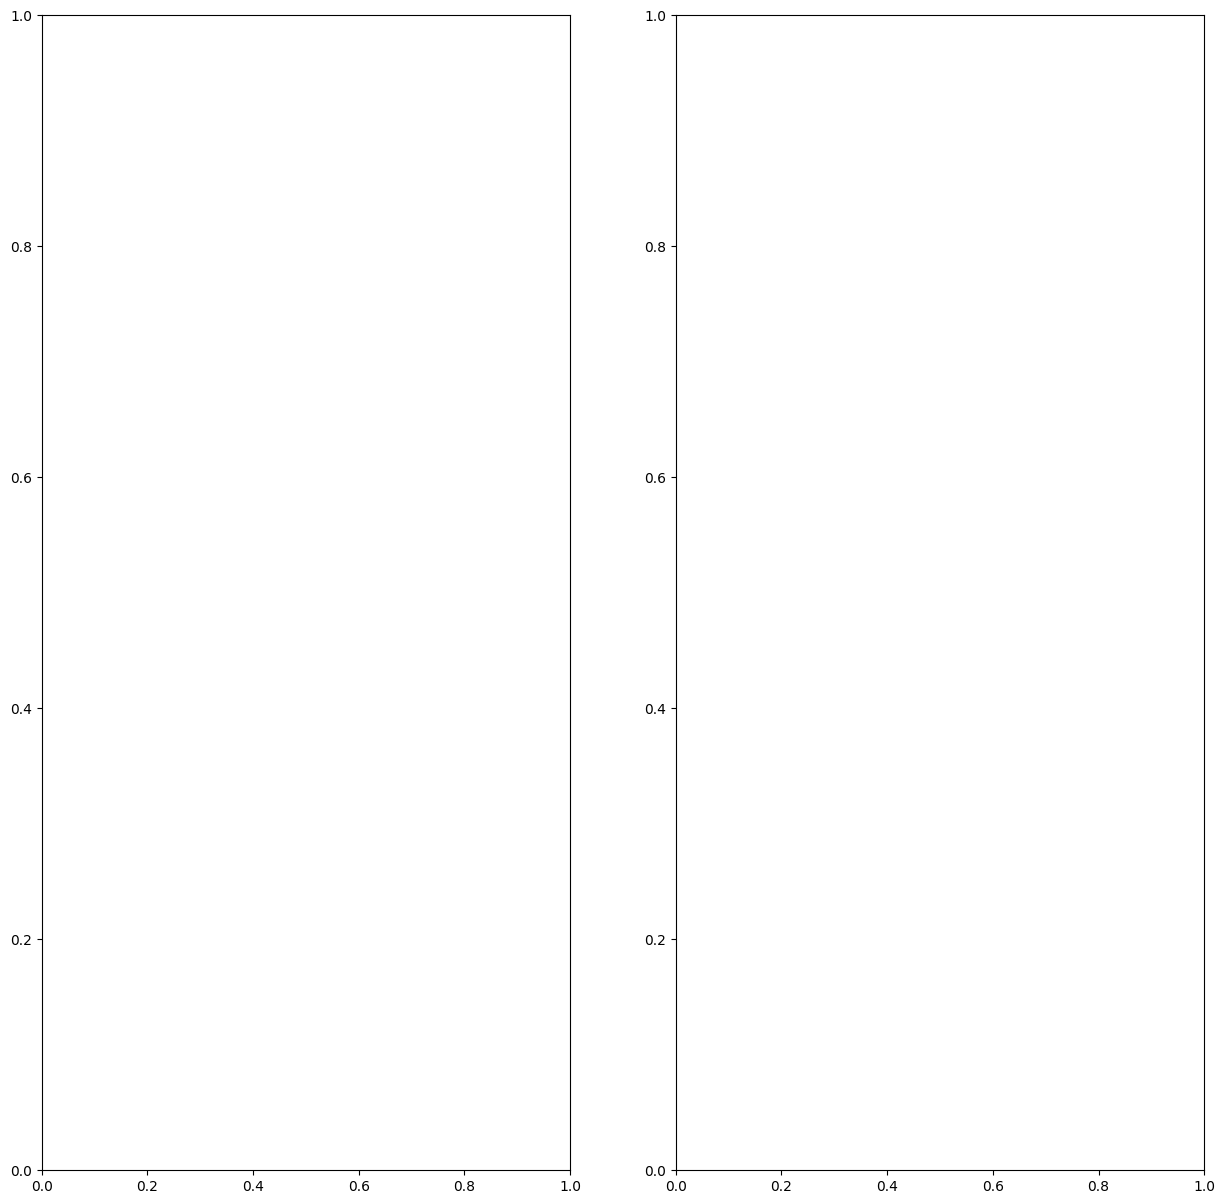

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

ax1.plot(losses)
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss")

ax2.plot(cs)
ax2.set_xlabel("Steps")
ax2.set_ylabel("$C_S$")

plt.grid(True, linestyle=":")
plt.show()